# Introduction

The below graphic, on the left, shows how counties report in the 2022 Georgia Senate election. The order of counties reporting tends to skews election results. If liberal counties report early, the phenomenon is sometimes referred to as the right hook. This notoriously happens in Florida, as early results make it seem as though democrats have secured victory, only to get hit with a right hook from late reporting counties from the conservative panhandle. 

The below graphic, on the right, shows how within a county, results get more Republican as counting progresses. Counts of in-person votes are more likely than overall vote counts to be for the Republican Party, while mail-in votes, and early in-person votes, which are often counted first, tend to be more Democrat.

![county_vote_change](./viz/inter_intra_county.gif)

![map_of_county_vote_change](./viz/Gwinnett_county.gif)

In this third installment of Predicting Election Night Margin, we're going to combine the two models from the previous two sections that predict:
1. intra-county election prediction model -  a regression model that predicts final county results based on early returns
2. inter-county election prediction model -  a mixed-effects model that predicts final, state-wide results for all counties based only on counties that have reported. 
We're going to build a comprehensive election night model that predicts final state wide results based on counties and votes reported throughout election night. We'll measure the effectiveness of our model based on how much better our model predicts final, state-wide results, as opposed to actual results reported so-far on election night.

# Data Acquisition

In [147]:
### Import required libraries.
import math
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import re
import requests
import json
import boto3
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from datetime import datetime
from IPython.display import HTML,display,Javascript
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import r, pandas2ri
import rpy2.ipython.html
base = importr('base')
lme = importr('lme4')
arm = importr('arm')
stats = importr('stats')


rpy2.ipython.html.init_printing()
utils = importr('utils')


import warnings
warnings.filterwarnings('ignore')


from urllib.request import urlopen, Request
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline


## Loading Dataset

### First, Load the data sets used in part 2
This is the data used to build our inter-county model. The model used to predict state-wide results based on counties that have reported so-far
1. [2014 United States Senate Election](https://results.enr.clarityelections.com/GA/54042/149045/en/reports.html)
2. [2016 United States Presidential eleciton](https://results.enr.clarityelections.com/GA/63991/184321/en/reports.html)
3. [2018 Georgia Gubernatorial Election](https://results.enr.clarityelections.com/GA/91639/Web02-state.221451)
4. [2020 United States Presidential eleciton](https://results.enr.clarityelections.com/GA/107231/web.264614/#/summary)
5. [2021 United States Senate runoff election.](https://results.enr.clarityelections.com/GA/107556/web.274956/#/summary)
6. [2022 United States Senate Election](https://results.enr.clarityelections.com/GA/115465/web.307039/#/summary)

and to test our model we'll use [2022 United States Senate runoff election.](https://results.enr.clarityelections.com/GA/116564/web.307039/#/summary)

In [8]:

def column_trim(columns):
    #parse and clean column names
    renamed_columns=[]
    pattern = r'[(,)]'
    for column in columns:
        l = re.split(pattern,column[0])
        renamed_columns.append((' '.join((l[-2][0] if len(l)>1 else '',column[1])).strip()))
    return(renamed_columns)
def county_level_election_df_format(county_count_df):
    #format data frame to only include 
    #1. democrat results by county 
    #2. state wide democrat results 
    #3. county name
    #4. registered voter precentage of county
    county_count_df.columns=column_trim(county_count_df.columns)
    df_columns=[i for i in ['R Total Votes', 'D Total Votes','L Total Votes','Registered Voters'] if i in county_count_df.columns]
    county_total_df=county_count_df[df_columns]
    county_percent_df=county_total_df
    party_columns=[i for i in county_percent_df.columns if i not in ['Registered Voters']]
    county_percent_df[party_columns]=county_total_df[party_columns].div(county_total_df[party_columns].sum(axis=1), axis=0)
    county_percent_df['state_dem_vote_pct']=county_percent_df.iloc[-1]['D Total Votes']
    county_percent_df.rename(columns={'Registered Voters':'registered_voters',
                                      'D Total Votes':'county_dem_vote_pct'}, 
                             inplace=True)
    county_percent_df.index = county_percent_df.index.set_names(['county'])
    county_percent_df=county_percent_df.reset_index()[['registered_voters',
                                                       'county',
                                                       'county_dem_vote_pct',
                                                       'state_dem_vote_pct']].iloc[:-1] 
    return(county_percent_df)
ga_14_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2014/detail.xlsx', 'rb'),
                                    index_col=0,
                                    header=[1, 2], 
                                    sheet_name='2')
ga_14_county_percent_df=county_level_election_df_format(ga_14_county_count_df)

ga_16_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2016/detail.xlsx', 'rb'),
                                    index_col=0,
                                    header=[1, 2], 
                                    sheet_name='2')
ga_16_county_percent_df=county_level_election_df_format(ga_16_county_count_df)

ga_18_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2018/detail.xlsx', 'rb'),
                                    index_col=0,
                                    header=[1, 2], 
                                    sheet_name='2')
ga_18_county_percent_df=county_level_election_df_format(ga_18_county_count_df)

ga_20_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2020/detail.xlsx', 'rb'),
                                    index_col=0,
                                    header=[1, 2], 
                                    sheet_name='1')
ga_20_county_percent_df=county_level_election_df_format(ga_20_county_count_df)

ga_21_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2021/detail.xlsx', 'rb'),
                                    index_col=0,
                                    header=[1, 2], 
                                    sheet_name='2')
ga_21_county_percent_df=county_level_election_df_format(ga_21_county_count_df)

ga_22_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2022/detail.xlsx', 'rb'),
                                    index_col=0,
                                    header=[1, 2], 
                                    sheet_name='2')
ga_22_county_percent_df=county_level_election_df_format(ga_22_county_count_df)

ga_22_gov_county_count_df=pd.read_excel(open('./data/CountyLevelElectionResults/2022/detail.xlsx', 'rb'),
                                        index_col=0,
                                        header=[1, 2], 
                                        sheet_name='3')
ga_22_gov_county_percent_df=county_level_election_df_format(ga_22_gov_county_count_df)

In [9]:
ga_county_percent_df=pd.concat([ga_22_county_percent_df,
                                ga_21_county_percent_df,
                                ga_20_county_percent_df, 
                                ga_18_county_percent_df,
                                ga_16_county_percent_df,
                                ga_14_county_percent_df]).reset_index(drop=True)

### Next, we'll load the data sets used in part 1
This is the data used to build our intra-county model. The model used to predict final results based on early returns. 

* fips2county data. This data will be used cross reference fips codes with county names
* census state cartographic boundary files. This data will be used to draw state boarders for state map using geopandas 
* census county cartographic boundary files. This data will be used to draw county boarders for state map using geopandas 

load AP election capture data from the Georgia Senate Election. The results is a dictionary indexed by capture time of election results through election night. 

* General election capture will be used to train the model
* runoff election. will be used for test data.

In [13]:
def pandasDF2R(df):
    with robjects.conversion.localconverter(rpy2.robjects.default_converter + pandas2ri.converter):
        if hasattr(robjects.conversion,'py2ri'):
            ret = robjects.conversion.py2ri(df)
        else:
            ret = robjects.conversion.py2rpy(df)
    return ret
#build model
MLexamp = lme.lmer(formula = 'county_dem_vote_pct ~ state_dem_vote_pct  + (1|county)',
                   weights = robjects.FloatVector(ga_county_percent_df['registered_voters']), 
                   data=pandasDF2R(ga_county_percent_df))
#get slope and intecept for each county
groups_df=pandas2ri.rpy2py_dataframe(stats.coef(MLexamp)[0])
groups_df=groups_df.rename(columns={"(Intercept)": "intercept", "state_dem_vote_pct": "slope"})
def download(url: str, dest_folder: str):
    filename = url.split('/')[-1].replace(" ", "_")
    file_path = os.path.join(dest_folder, filename)
    
    if not os.path.exists(file_path):
        os.makedirs(dest_folder, exist_ok=True)
        r = requests.get(url, stream=True)
        if r.ok:
            print("saving to", os.path.abspath(file_path))
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 8):
                    if chunk:
                        f.write(chunk)
                        f.flush()
                        os.fsync(f.fileno())
        else:  
            print("Download failed: status code ",r.status_code)
            print(r.text)
        
        
# Download fips data, and load it into data frame
download("https://raw.githubusercontent.com/ChuckConnell/articles/master/fips2county.tsv", dest_folder="./data")
fips_df = pd.read_csv('./data/fips2county.tsv', sep='\t', header='infer', dtype=str, encoding='latin-1')
fips_df=fips_df.set_index('CountyFIPS')
def build_ap_eleciton_data(eleciton_data):
    county_fipps=set(eleciton_data.keys())-set(['metadata','summary'])
    election_data_counties=[eleciton_data[code] for code in county_fipps ]
    df=pd.json_normalize(election_data_counties,'candidates',['fipsCode',
                                                              'precinctsReporting',
                                                              'precinctsTotal',
                                                              'eevp',
                                                              ['parameters','vote','expected','actual'],
                                                              ['parameters','vote','total'],
                                                              ['parameters','vote','registered']])


    df['candidateID']=df['candidateID'].apply(lambda x: eleciton_data['metadata']['candidates'][x]['first']+\
                                                        eleciton_data['metadata']['candidates'][x]['last'])
    df['county']=fips_df.loc[df['fipsCode']].reset_index()['CountyName']
    df=groups_df.join(df.set_index('county')).reset_index()
    df = df.set_index(['fipsCode','candidateID'])
    return df


def ap_election_from_file(election_dir):
    files = os.listdir(election_dir)
    files = sorted([(f.split('_')[0],f) for f in files if os.path.isfile(election_dir+'/'+f)]) 
    #dictionary indexed by capture time, holds dataframe of county results 
    election_timeseries={}
    #loop through each election capture 
    for epoch, file in files:
        with open(election_dir+file) as f:
            eleciton_data = json.loads(f.read())
        election_timeseries[epoch]=build_ap_eleciton_data(eleciton_data)
    return election_timeseries

def ap_election_from_S3(bucket_name, prefix ):
    s3 = boto3.client('s3')
    resp = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    files = [ obj['Key']   for obj in resp['Contents']]
    files = sorted(map(lambda file: (file.split('/')[-1].split('_')[0],file), files))
    election_timeseries={}
    for epoch, file in files:
        data=s3.get_object(Bucket=bucket_name, Key=file )
        contents = data['Body'].read()
        eleciton_data = json.loads(contents.decode("utf-8"))
        election_timeseries[epoch]=build_ap_eleciton_data(eleciton_data)
    return election_timeseries


election_timeseries=ap_election_from_file('./data/2022/GA/ussenate/general/')
runoff_timeseries=ap_election_from_file('./data/2022/GA/ussenate/runoff/')

# Fitting Forecasting Models

### Build intra-county election prediction model

First we re-create our regression model that predicts final county results based on early returns from part 1

In [14]:
from collections import defaultdict
general_epochs=list(election_timeseries.keys())
last_election_capture=election_timeseries[general_epochs[-1]]

class Election_Model():
    def __init__(self,model,*model_list_args,**model_dict_args):
        def default_value():
            return model(*model_list_args,**model_dict_args)
        def default_index():
            return defaultdict(default_value)
         
        self.election_model_dict= defaultdict(default_index)

    def __getitem__(self, index):
        return self.election_model_dict[index]

        
    

linear_model = Election_Model(LinearRegression);


for fips in last_election_capture.reset_index()['fipsCode'].unique():
    for candidate_id in last_election_capture.loc[fips].index:

        df=pd.concat([election_timeseries[epoch].loc[fips,candidate_id] for epoch in general_epochs],  axis=1).T
        df=df.reset_index(drop=True)
        df['ReportingPct']=(df['parameters.vote.total']/df['parameters.vote.expected.actual'])*100
        edf=df[0<df['votePct'] ].drop_duplicates()

        x = np.array([edf['ReportingPct'].array.astype(float)]).T
        y = np.array([edf['votePct'].array.astype(float)]).T

        linear_model[fips][candidate_id].fit(x, y)

### Build  inter-county election prediction model

next, we build our mixed-effects model that predicts final, state-wide results for all counties based only on counties that have reported from part 2

In [15]:
def pandasDF2R(df):
    with robjects.conversion.localconverter(rpy2.robjects.default_converter + pandas2ri.converter):
        if hasattr(robjects.conversion,'py2ri'):
            ret = robjects.conversion.py2ri(df)
        else:
            ret = robjects.conversion.py2rpy(df)
    return ret
#build model
MLexamp = lme.lmer(formula = 'county_dem_vote_pct ~ state_dem_vote_pct  + (1|county)',
                   weights = robjects.FloatVector(ga_county_percent_df['registered_voters']), 
                   data=pandasDF2R(ga_county_percent_df))
#get slope and intecept for each county
groups_df=pandas2ri.rpy2py_dataframe(stats.coef(MLexamp)[0])
groups_df=groups_df.rename(columns={"(Intercept)": "intercept", "state_dem_vote_pct": "slope"})

In [16]:
MLexamp_summary=base.summary(MLexamp)

MLexamp_summary_dict=dict(zip(MLexamp_summary.names, list(MLexamp_summary)))


dash = '-' * 80
double_dash = '='* 80
print('{:<15}{:<50s}'.format("","Mixed Linear Model Regression Results"))
print(double_dash)
print('{:<25}{:<70s}'.format("Method:",MLexamp_summary_dict['methTitle'][0]))
print('{:<25}{:<70n}'.format("No. Groups",MLexamp_summary_dict['ngrps'][0]))
print(dash)
print('{:<25}{:<15s}{:<15s}{:<15s}'.format("","Coef","Std.Err.","z"))
print(dash)
print('{:<25}{:<15n}{:<15n}{:<15n}'.format("Intercept",MLexamp_summary_dict['coefficients'][0],MLexamp_summary_dict['coefficients'][2],MLexamp_summary_dict['coefficients'][4]))
print('{:<25}{:<15n}{:<15n}{:<15n}'.format("state_dem_vote_pct",MLexamp_summary_dict['coefficients'][1],MLexamp_summary_dict['coefficients'][3],MLexamp_summary_dict['coefficients'][5] ))




               Mixed Linear Model Regression Results             
Method:                  Linear mixed model fit by REML                                        
No. Groups               159                                                                   
--------------------------------------------------------------------------------
                         Coef           Std.Err.       z              
--------------------------------------------------------------------------------
Intercept                -0.176067      2.53148        -0.0695511     
state_dem_vote_pct       1.08323        0.0390714      27.7244        


# Applying The Model To Real Time Data

We're going to apply a combination of our intra-county and inter-county election model to real-time capture of the 2022 senate runoff election., and compare our projected results to true results reported on election night. Two time series arrays will hold the data we're going to contrast.
1.  `reporting_dem_precent` - Results as they were at each time capture of election results during election night. This is our baseline results 
2.  `projected_dem_precent` - Our projected state-wide results based on the reported results. This is product of our model

Before we build our comprehensive model, there's two ways we can calculate `projected_dem_precent`. The way we calculated projected dem precent in part 2 of Predicting Election Night Margin was by calculating the precent by votes reported so far, but we can also calculate the projected vote precent by expected final vote totals. We'll test both ways for calculating `projected_dem_precent` to see which way produced better results. First we'll recreate the projected dem votes as we calculated in part 2, then we'll test the other mothed, with expected final vote totals, before we apply both intra-county and inter county models to both methods. 


|                                   | votes reported so far  | Projected Final Vote Totals      |
| ----------------------            | ----------- -----------|-----------  -----------|
| **Inter-County Model Alone**      | [Inter-County Model With Votes Reported So Far](#Inter-County-Model-With-Votes-Reported-So-Far) | [Inter-County Model With Projected Final Vote Totals](#Inter-County-Model-With-Projected-Final-Vote-Totals)                   |
| **Intra and Inter-County Model**  | [Comprehensive Election Night Margin Model With Votes Reported So Far](#Comprehensive-Election-Night-Margin-Model-With-Votes-Reported-So-Far)| [Comprehensive Election Night Margin Model With Projected Final Vote Totals](#Comprehensive-Election-Night-Margin-Model-With-Projected-Final-Vote-Totals) |


## Inter-County Model With Votes Reported So Far

This is just a re-creation of the model and method used in part 2. As we work towards our comprehensive election night model, we'll compare our results to results as they were reported on election night, we'll call these our baseline results, and we'll compare our results to the model and method from part 2 as we're re-creating in this section.

In [131]:
runoff_epoch_keys=list(runoff_timeseries.keys())
final_result=runoff_timeseries[runoff_epoch_keys[-1]]
true_result=final_result.xs('RaphaelWarnock', level='candidateID')['voteCount'].sum()/final_result['voteCount'].sum()
error=0
projected_dem_precent=[]
reporting_dem_precent=[]
dem_precent_epoch=[]
final_result_dem_precent=(final_result.xs('RaphaelWarnock', level='candidateID')['parameters.vote.total']*final_result.xs('RaphaelWarnock', level='candidateID')['votePct']/100).sum()/final_result.xs('RaphaelWarnock', level='candidateID')['parameters.vote.total'].sum()
for epoch in runoff_epoch_keys:
    df=runoff_timeseries[epoch]
    reporting_indexes=df[df['eevp']>0].index
    none_reporting_indexes=df[df['eevp']==0].index
    if len(reporting_indexes)>0 :
        dem_reporting_df=df.loc[reporting_indexes].xs('RaphaelWarnock', level='candidateID')
        reporting_dem_vote_total_df=dem_reporting_df['votePct']*dem_reporting_df['parameters.vote.total']/100
        #calculate precent reporting so far
        total_precent_reporting=dem_reporting_df['parameters.vote.total'].sum()/(dem_reporting_df['parameters.vote.expected.actual'].sum())
        #apply mixed effects model to to vote pct of reporting counties to get state-wide expected vote pct for each county
        expected_state_vote_df=(dem_reporting_df['votePct']/100.-dem_reporting_df['intercept'])/dem_reporting_df['slope']
        #get averaged state wide vote from all counties
        expected_state_vote=(dem_reporting_df['parameters.vote.registered']*expected_state_vote_df).sum()/dem_reporting_df['parameters.vote.registered'].sum()



        if(len(none_reporting_indexes)>0):
            dem_none_reporting_df=df.loc[none_reporting_indexes].xs('RaphaelWarnock', level='candidateID')
            none_reporting_predicted_df=dem_none_reporting_df['slope']*expected_state_vote+dem_none_reporting_df['intercept']
            #use precent reporting so far * non reporting expected votes* projected precent democrat 
            none_reporting_dem_vote_total_df=total_precent_reporting*dem_none_reporting_df['parameters.vote.expected.actual']*none_reporting_predicted_df
            sum_dem_vote=none_reporting_dem_vote_total_df.sum()+reporting_dem_vote_total_df.sum()
            sum_dem_vote_expected=((total_precent_reporting*df['parameters.vote.expected.actual']/2).sum())
            projected_dem_precent.append(sum_dem_vote/sum_dem_vote_expected)
        else:
             projected_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        reporting_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        dem_precent_epoch.append(epoch)


In [132]:
def RMSD(dfp,dfx):
    return(((dfp - dfx) ** 2).mean() ** .5)
error = RMSD(pd.DataFrame(reporting_dem_precent),pd.DataFrame([final_result_dem_precent]*len(reporting_dem_precent)))[0]
print(f'Cumulative baseline error of Raphael Warnock\'s margins in the runoff election. {error=}')
error = RMSD(pd.DataFrame(projected_dem_precent),pd.DataFrame([final_result_dem_precent]*len(projected_dem_precent)))[0]
print(f'Cumulative Inter-County Model With Votes Reported So Far error of Raphael Warnock\'s margins in the runoff election. {error=}')



Cumulative baseline error of Raphael Warnock's margins in the runoff election. error=0.038462887926662415
Cumulative Inter-County Model With Votes Reported So Far error of Raphael Warnock's margins in the runoff election. error=0.023219842501452988


[Text(0.5, 1.0, 'Democrat Margin 2022 Georgia Senate Runoff')]

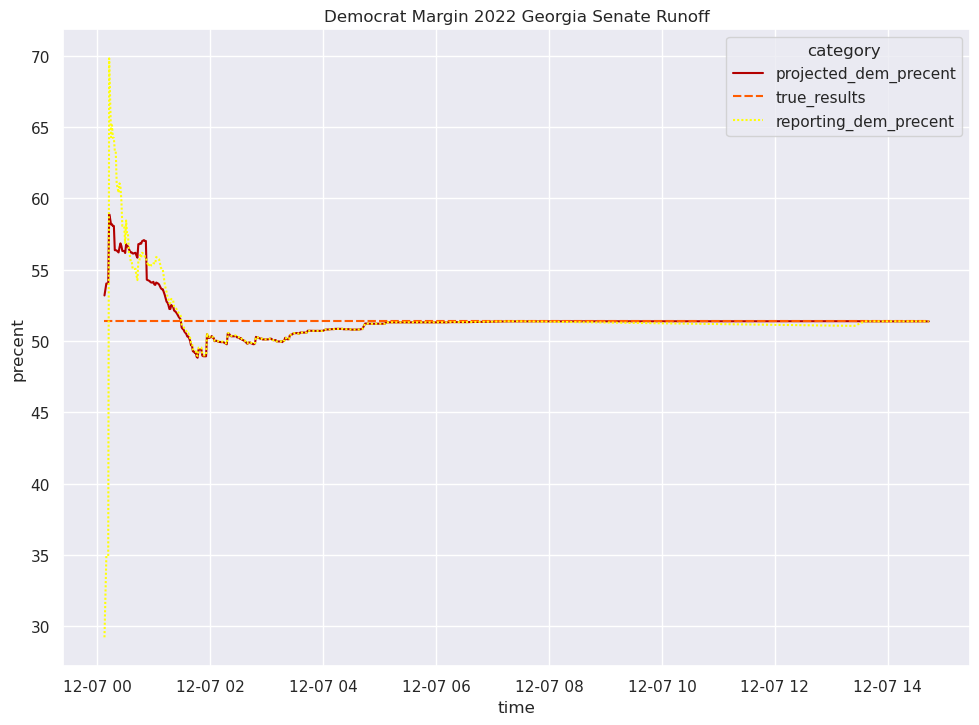

In [133]:
dem_precent_df = pd.DataFrame()
dem_precent_df['projected_dem_precent'] = projected_dem_precent
dem_precent_df['true_results'] = [final_result_dem_precent]*len(projected_dem_precent)
dem_precent_df['reporting_dem_precent'] = reporting_dem_precent
dem_precent_df=dem_precent_df*100
dem_precent_df['time']=[datetime.fromtimestamp(int(epoch)) for epoch in dem_precent_epoch ]
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Plot the responses for different events and regions

sns.lineplot(x="time", 
             y="precent",
             style="category",
             hue="category",
             palette = 'hot',
             data=dem_precent_df.melt(id_vars=['time'],
                                      var_name='category', 
                                      value_name='precent')).set(title='Democrat Margin 2022 Georgia Senate Runoff')


[Text(0.5, 1.0, 'Deviation From True Results')]

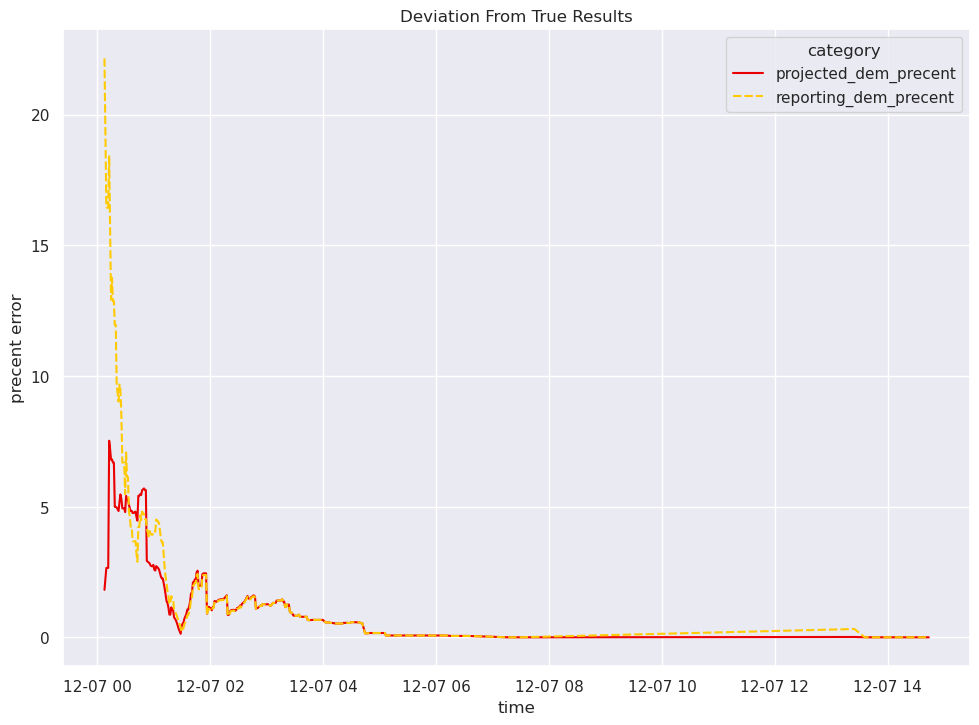

In [134]:
dem_precent_df = pd.DataFrame()
dem_precent_df['projected_dem_precent'] = projected_dem_precent
dem_precent_df['projected_dem_precent'] =abs(dem_precent_df['projected_dem_precent'] -final_result_dem_precent)
dem_precent_df['reporting_dem_precent'] = reporting_dem_precent
dem_precent_df['reporting_dem_precent'] =abs(dem_precent_df['reporting_dem_precent'] -final_result_dem_precent)
dem_precent_df=dem_precent_df*100


dem_precent_df['time']=[datetime.fromtimestamp(int(epoch)) for epoch in dem_precent_epoch ]
# Plot the responses for different events and regions
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", 
             y="precent error",
             style="category",
             hue="category",
             palette = 'hot',
             data=dem_precent_df.melt(id_vars=['time'],
                                      var_name='category', 
                                      value_name='precent error')).set(title='Deviation From True Results')

## Inter-County Model With Projected Final Vote Totals

The is still the model used in part 2, but we modify the method used to calculate `projected_dem_precent`. Instead of using votes reported so far at each point of election capture, we'll use the projected final vote count to project our Democrat margin. 

In [135]:
runoff_epoch_keys=list(runoff_timeseries.keys())
final_result=runoff_timeseries[runoff_epoch_keys[-1]]
true_result=final_result.xs('RaphaelWarnock', level='candidateID')['voteCount'].sum()/final_result['voteCount'].sum()
error=0
projected_dem_precent=[]
reporting_dem_precent=[]
dem_precent_epoch=[]
for epoch in runoff_epoch_keys:
    df=runoff_timeseries[epoch]
    reporting_indexes=df[df['eevp']>0].index
    none_reporting_indexes=df[df['eevp']==0].index
    if len(reporting_indexes)>0 :
        final_dem_results_df=final_result.loc[reporting_indexes].xs('RaphaelWarnock', level='candidateID')['votePct']/100
        dem_reporting_df=df.loc[reporting_indexes].xs('RaphaelWarnock', level='candidateID')
        reporting_dem_vote_total_df=dem_reporting_df['votePct']*dem_reporting_df['parameters.vote.total']/100
        #calculate precent reporting so far
        total_precent_reporting=dem_reporting_df['parameters.vote.total'].sum()/(dem_reporting_df['parameters.vote.expected.actual'].sum())
        expected_state_vote_df=(dem_reporting_df['votePct']/100.-dem_reporting_df['intercept'])/dem_reporting_df['slope']
        expected_state_vote=(dem_reporting_df['parameters.vote.registered']*expected_state_vote_df).sum()/dem_reporting_df['parameters.vote.registered'].sum()

        if(len(none_reporting_indexes)>0):
            dem_none_reporting_df=df.loc[none_reporting_indexes].xs('RaphaelWarnock', level='candidateID')
            none_reporting_predicted_df=dem_none_reporting_df['slope']*expected_state_vote+dem_none_reporting_df['intercept']
            final_dem_results_df=final_dem_results_df.append(final_result.loc[none_reporting_indexes].xs('RaphaelWarnock', level='candidateID')['votePct']/100)
            #use precent reporting so far * non reporting expected votes* projected precent democrat 
            none_reporting_dem_vote_total_df=dem_none_reporting_df['parameters.vote.expected.actual']*none_reporting_predicted_df
            none_reporting_dem_vote_total=none_reporting_dem_vote_total_df.sum()
        else:
            none_reporting_dem_vote_total=0
        sum_dem_vote=none_reporting_dem_vote_total+(dem_reporting_df['votePct']*dem_reporting_df['parameters.vote.expected.actual']/100).sum()
        sum_dem_vote_expected=((df['parameters.vote.expected.actual']/2).sum())
        projected_dem_precent.append(sum_dem_vote/sum_dem_vote_expected)
        #else:
        #     projected_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        reporting_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        dem_precent_epoch.append(epoch)




In [136]:
def RMSD(dfp,dfx):
    return(((dfp - dfx) ** 2).mean() ** .5)
error = RMSD(pd.DataFrame(reporting_dem_precent),pd.DataFrame([final_result_dem_precent]*len(reporting_dem_precent)))[0]
print(f'Cumulative baseline error of Raphael Warnock\'s margins in the runoff election. {error=}')
error = RMSD(pd.DataFrame(projected_dem_precent),pd.DataFrame([final_result_dem_precent]*len(projected_dem_precent)))[0]
print(f'Cumulative Inter-County Model With Projected Final Vote Totals error of Raphael Warnock\'s margins in the runoff election. {error=}')



Cumulative baseline error of Raphael Warnock's margins in the runoff election. error=0.038462887926662415
Cumulative Inter-County Model With Projected Final Vote Totals error of Raphael Warnock's margins in the runoff election. error=0.03316863318792405


[Text(0.5, 1.0, 'Democrat Margin 2022 Georgia Senate Runoff')]

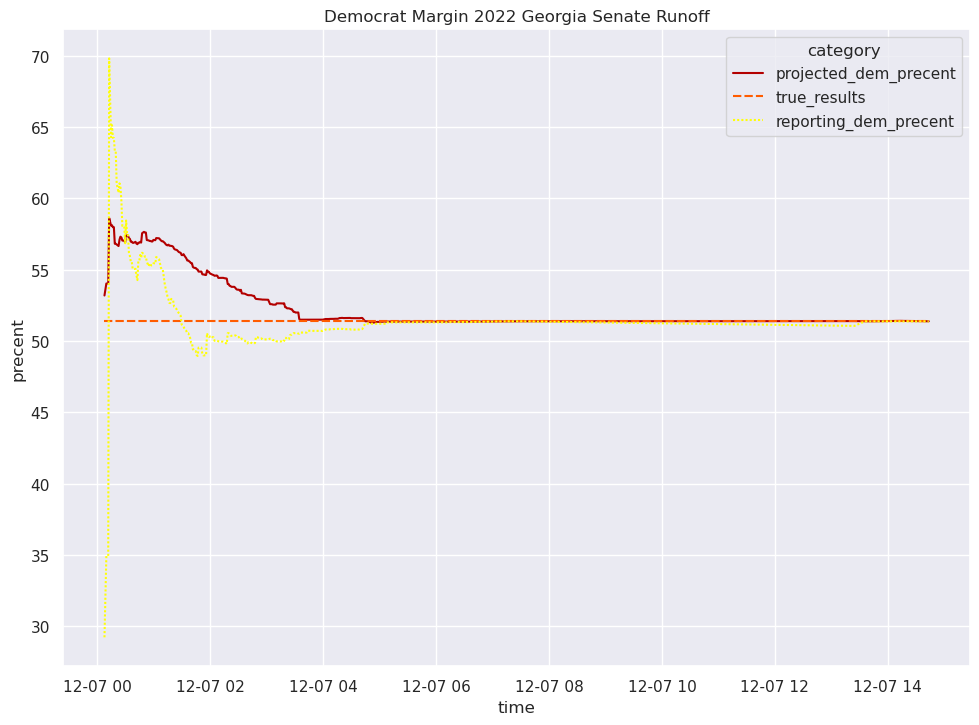

In [137]:
dem_precent_df = pd.DataFrame()
dem_precent_df['projected_dem_precent'] = projected_dem_precent
dem_precent_df['true_results'] = [final_result_dem_precent]*len(projected_dem_precent)
dem_precent_df['reporting_dem_precent'] = reporting_dem_precent
dem_precent_df=dem_precent_df*100
dem_precent_df['time']=[datetime.fromtimestamp(int(epoch)) for epoch in dem_precent_epoch ]

# Plot the responses for different events and regions

sns.lineplot(x="time", 
             y="precent",
             style="category",
             hue="category",
             palette = 'hot',
             data=dem_precent_df.melt(id_vars=['time'],
                                      var_name='category', 
                                      value_name='precent')).set(title='Democrat Margin 2022 Georgia Senate Runoff')


[Text(0.5, 1.0, 'Deviation From True Results')]

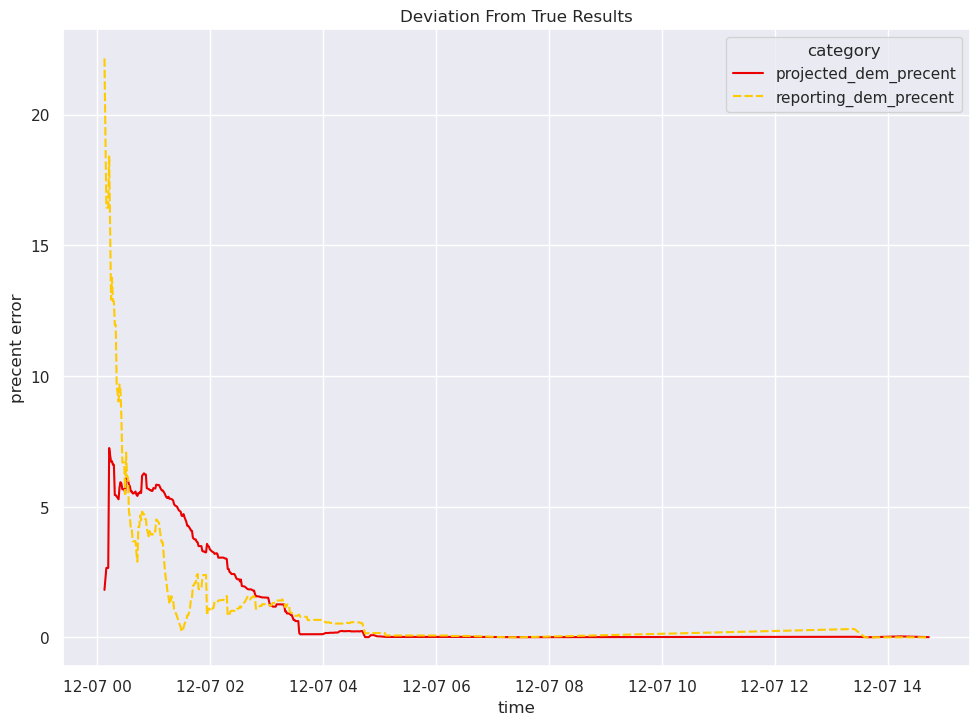

In [138]:
dem_precent_df = pd.DataFrame()
dem_precent_df['projected_dem_precent'] = projected_dem_precent
dem_precent_df['projected_dem_precent'] =abs(dem_precent_df['projected_dem_precent'] -final_result_dem_precent)
dem_precent_df['reporting_dem_precent'] = reporting_dem_precent
dem_precent_df['reporting_dem_precent'] =abs(dem_precent_df['reporting_dem_precent'] -final_result_dem_precent)
dem_precent_df=dem_precent_df*100

dem_precent_df['time']=[datetime.fromtimestamp(int(epoch)) for epoch in dem_precent_epoch ]
# Plot the responses for different events and regions
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", 
             y="precent error",
             style="category",
             hue="category",
             palette = 'hot',
             data=dem_precent_df.melt(id_vars=['time'],
                                      var_name='category',
                                      value_name='precent error')).set(title='Deviation From True Results')

Notice that using projected final vote totals to calculate `projected_dem_precent` actually produced worse results. This was the reason it wasn't used in part 2. 

## Comprehensive Election Night Margin Model With Votes Reported So Far

We're finally making headway towards the objective of this section. We're incorporating both the intra-county model from part 1, and the inter county model of part 2 into building a comprehensive election night model. First, we'll apply it to the votes reported so far, the same method used in the previous section.

In [139]:

runoff_epoch_keys=list(runoff_timeseries.keys())
final_result=runoff_timeseries[runoff_epoch_keys[-1]]
true_result=final_result.xs('RaphaelWarnock', level='candidateID')['voteCount'].sum()/final_result['voteCount'].sum()
error=0
projected_dem_precent=[]
reporting_dem_precent=[]
dem_precent_epoch=[]
final_result_dem_precent=(final_result.xs('RaphaelWarnock', level='candidateID')['parameters.vote.total']*final_result.xs('RaphaelWarnock', level='candidateID')['votePct']/100).sum()/final_result.xs('RaphaelWarnock', level='candidateID')['parameters.vote.total'].sum()
for epoch in runoff_epoch_keys:
    df=runoff_timeseries[epoch]
    df['adjusted_votePct']= df['votePct'].copy()
    reporting_indexes=df[df['eevp']>0].index
    
    if len(reporting_indexes):
        df.loc[reporting_indexes,'adjusted_votePct']=np.array([ linear_model[fips][candidate_id].predict(np.array([[100]]))[0][0]- linear_model[fips][candidate_id].predict(np.array([[ df.loc[fips, candidate_id]['eevp']  ]]))[0][0] for fips, candidate_id in reporting_indexes])  + df.loc[reporting_indexes]['votePct']
    
    
    none_reporting_indexes=df[df['eevp']==0].index
    if len(reporting_indexes)>0 :
        dem_reporting_df=df.loc[reporting_indexes].xs('RaphaelWarnock', level='candidateID')
        reporting_dem_vote_total_df=dem_reporting_df['votePct']*dem_reporting_df['parameters.vote.total']/100
        #calculate precent reporting so far
        total_precent_reporting=dem_reporting_df['parameters.vote.total'].sum()/(dem_reporting_df['parameters.vote.expected.actual'].sum())
        expected_state_vote_df=(dem_reporting_df['adjusted_votePct']/100.-dem_reporting_df['intercept'])/dem_reporting_df['slope']
        expected_state_vote=(dem_reporting_df['parameters.vote.registered']*expected_state_vote_df).sum()/dem_reporting_df['parameters.vote.registered'].sum()



        if(len(none_reporting_indexes)>0):
            dem_none_reporting_df=df.loc[none_reporting_indexes].xs('RaphaelWarnock', level='candidateID')
            none_reporting_predicted_df=dem_none_reporting_df['slope']*expected_state_vote+dem_none_reporting_df['intercept']
            #use precent reporting so far * non reporting expected votes* projected precent democrat 
            none_reporting_dem_vote_total_df=total_precent_reporting*dem_none_reporting_df['parameters.vote.expected.actual']*none_reporting_predicted_df
            sum_dem_vote=none_reporting_dem_vote_total_df.sum()+reporting_dem_vote_total_df.sum()
            sum_dem_vote_expected=((total_precent_reporting*df['parameters.vote.expected.actual']/2).sum())
            projected_dem_precent.append(sum_dem_vote/sum_dem_vote_expected)
        else:
             projected_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        reporting_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        dem_precent_epoch.append(epoch)



In [140]:
def RMSD(dfp,dfx):
    return(((dfp - dfx) ** 2).mean() ** .5)
error = RMSD(pd.DataFrame(reporting_dem_precent),pd.DataFrame([final_result_dem_precent]*len(reporting_dem_precent)))[0]
print(f'Cumulative baseline error of Raphael Warnock\'s margins in the runoff election. {error=}')
error = RMSD(pd.DataFrame(projected_dem_precent),pd.DataFrame([final_result_dem_precent]*len(projected_dem_precent)))[0]
print(f'Cumulative Comprehensive Election Night Margin Model With Votes Reported So Far error of Raphael Warnock\'s margins in the runoff election. {error=}')



Cumulative baseline error of Raphael Warnock's margins in the runoff election. error=0.038462887926662415
Cumulative Comprehensive Election Night Margin Model With Votes Reported So Far error of Raphael Warnock's margins in the runoff election. error=0.017243178913870068


[Text(0.5, 1.0, 'Democrat Margin 2022 Georgia Senate Runoff')]

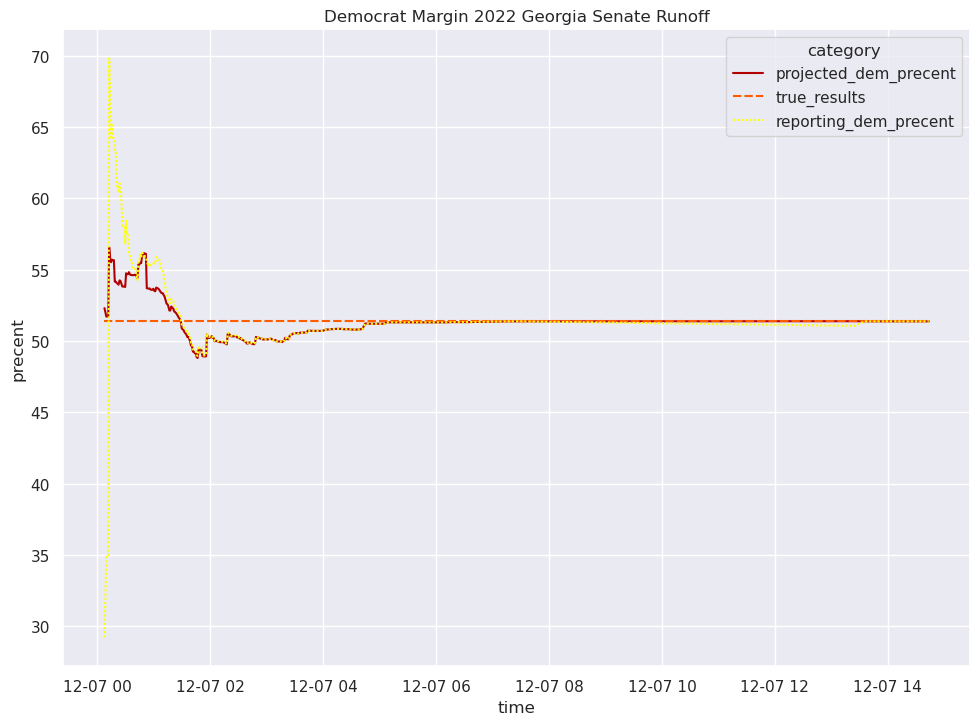

In [141]:
dem_precent_df = pd.DataFrame()
dem_precent_df['projected_dem_precent'] = projected_dem_precent
dem_precent_df['true_results'] = [final_result_dem_precent]*len(projected_dem_precent)
dem_precent_df['reporting_dem_precent'] = reporting_dem_precent
dem_precent_df=dem_precent_df*100
dem_precent_df['time']=[datetime.fromtimestamp(int(epoch)) for epoch in dem_precent_epoch ]

# Plot the responses for different events and regions
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", 
             y="precent",
             style="category",
             hue="category",
             palette = 'hot',
             data=dem_precent_df.melt(id_vars=['time'],
                                      var_name='category', 
                                      value_name='precent')).set(title='Democrat Margin 2022 Georgia Senate Runoff')

[Text(0.5, 1.0, 'Deviation From True Results')]

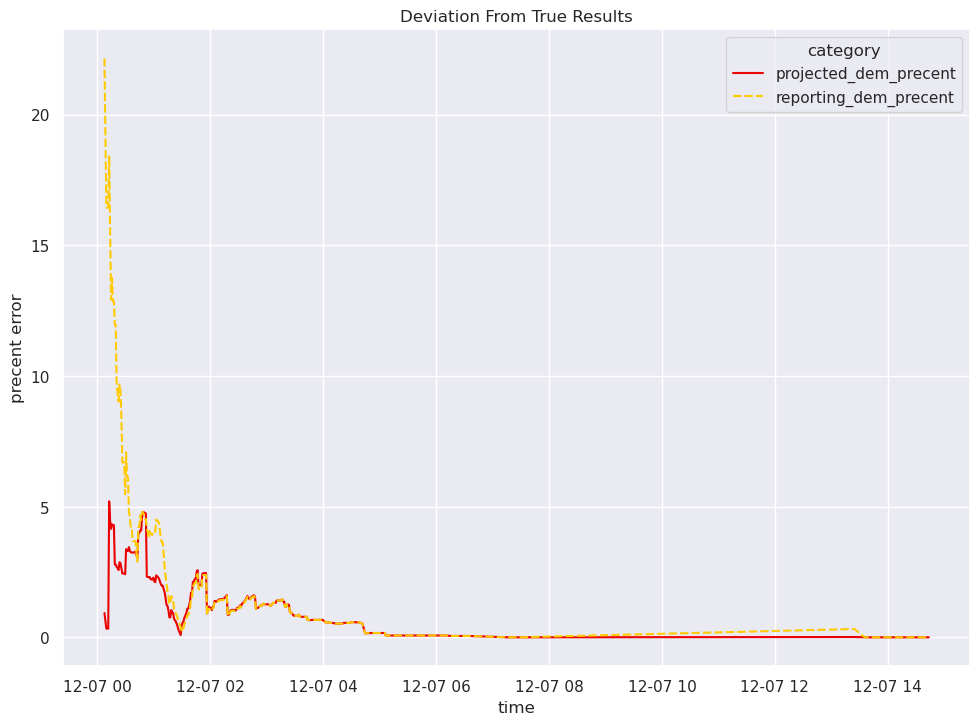

In [142]:
dem_precent_df = pd.DataFrame()
dem_precent_df['projected_dem_precent'] = projected_dem_precent
dem_precent_df['projected_dem_precent'] =abs(dem_precent_df['projected_dem_precent'] -final_result_dem_precent)
dem_precent_df['reporting_dem_precent'] = reporting_dem_precent
dem_precent_df['reporting_dem_precent'] =abs(dem_precent_df['reporting_dem_precent'] -final_result_dem_precent)
dem_precent_df=dem_precent_df*100

dem_precent_df['time']=[datetime.fromtimestamp(int(epoch)) for epoch in dem_precent_epoch ]
# Plot the responses for different events and regions
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", 
             y="precent error",
             style="category",
             hue="category",
             palette = 'hot',
             data=dem_precent_df.melt(id_vars=['time'],
                                      var_name='category', 
                                      value_name='precent error')).set(title='Deviation From True Results')

This is signification improvement over base line, and using the inter county model from part 2.

## Comprehensive Election Night Margin Model With Projected Final Vote Totals
Now we're going to apply both the inter-county mode and intra-county model with projected final vote counts to calculated `projected_dem_precent`.

In [143]:
runoff_epoch_keys=list(runoff_timeseries.keys())
#final_result=runoff_timeseries[runoff_epoch_keys[-1]]
true_result=final_result.xs('RaphaelWarnock', level='candidateID')['voteCount'].sum()/final_result['voteCount'].sum()
error=0
projected_dem_precent=[]
reporting_dem_precent=[]
dem_precent_epoch=[]
for epoch in runoff_epoch_keys:
    df=runoff_timeseries[epoch]
    df['adjusted_votePct']= df['votePct'].copy()
    runoff_indexes=df[df['eevp']>0].index
    if len(runoff_indexes):
        df.loc[runoff_indexes,'adjusted_votePct']=np.array([ linear_model[fips][candidate_id].predict(np.array([[100]]))[0][0]- linear_model[fips][candidate_id].predict(np.array([[ df.loc[fips, candidate_id]['eevp']  ]]))[0][0] for fips, candidate_id in runoff_indexes])  + df.loc[runoff_indexes]['votePct']
    reporting_indexes=df[df['eevp']>0].index
    none_reporting_indexes=df[df['eevp']==0].index
    if len(reporting_indexes)>0 :
        #final_dem_results_df=final_result.loc[reporting_indexes].xs('RaphaelWarnock', level='candidateID')['votePct']/100
        dem_reporting_df=df.loc[reporting_indexes].xs('RaphaelWarnock', level='candidateID')
        reporting_dem_vote_total_df=dem_reporting_df['votePct']*dem_reporting_df['parameters.vote.total']/100
        #calculate precent reporting so far
        total_precent_reporting=dem_reporting_df['parameters.vote.total'].sum()/(dem_reporting_df['parameters.vote.expected.actual'].sum())
        expected_state_vote_df=(dem_reporting_df['adjusted_votePct']/100.-dem_reporting_df['intercept'])/dem_reporting_df['slope']
        expected_state_vote=(dem_reporting_df['parameters.vote.registered']*expected_state_vote_df).sum()/dem_reporting_df['parameters.vote.registered'].sum()
        if(len(none_reporting_indexes)>0):
            dem_none_reporting_df=df.loc[none_reporting_indexes].xs('RaphaelWarnock', level='candidateID')
            none_reporting_predicted_df=dem_none_reporting_df['slope']*expected_state_vote+dem_none_reporting_df['intercept']
            #final_dem_results_df=final_dem_results_df.append(final_result.loc[none_reporting_indexes].xs('RaphaelWarnock', level='candidateID')['adjusted_votePct']/100)
            #use precent reporting so far * non reporting expected votes* projected precent democrat 
            none_reporting_dem_vote_total_df=dem_none_reporting_df['parameters.vote.expected.actual']*none_reporting_predicted_df
            none_reporting_dem_vote_total=none_reporting_dem_vote_total_df.sum()
        else:
            none_reporting_dem_vote_total=0


        sum_dem_vote=none_reporting_dem_vote_total+(dem_reporting_df['adjusted_votePct']*dem_reporting_df['parameters.vote.expected.actual']/100).sum()
        sum_dem_vote_expected=((df['parameters.vote.expected.actual']/2).sum())
        projected_dem_precent.append(sum_dem_vote/sum_dem_vote_expected)
        #else:
        #    projected_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        reporting_dem_precent.append(reporting_dem_vote_total_df.sum()/dem_reporting_df['parameters.vote.total'].sum())
        dem_precent_epoch.append(epoch)




In [144]:
def RMSD(dfp,dfx):
    return(((dfp - dfx) ** 2).mean() ** .5)
error = RMSD(pd.DataFrame(reporting_dem_precent),pd.DataFrame([final_result_dem_precent]*len(reporting_dem_precent)))[0]
print(f'Cumulative baseline error of Raphael Warnock\'s margins in the runoff election. {error=}')
error = RMSD(pd.DataFrame(projected_dem_precent),pd.DataFrame([final_result_dem_precent]*len(projected_dem_precent)))[0]
print(f'Cumulative Comprehensive Election Night Margin Model With Projected Final Vote Totals error of Raphael Warnock\'s margins in the runoff election. {error=}')



Cumulative baseline error of Raphael Warnock's margins in the runoff election. error=0.038462887926662415
Cumulative Comprehensive Election Night Margin Model With Projected Final Vote Totals error of Raphael Warnock's margins in the runoff election. error=0.014088298616192034


[Text(0.5, 1.0, 'Democrat Margin 2022 Georgia Senate Runoff')]

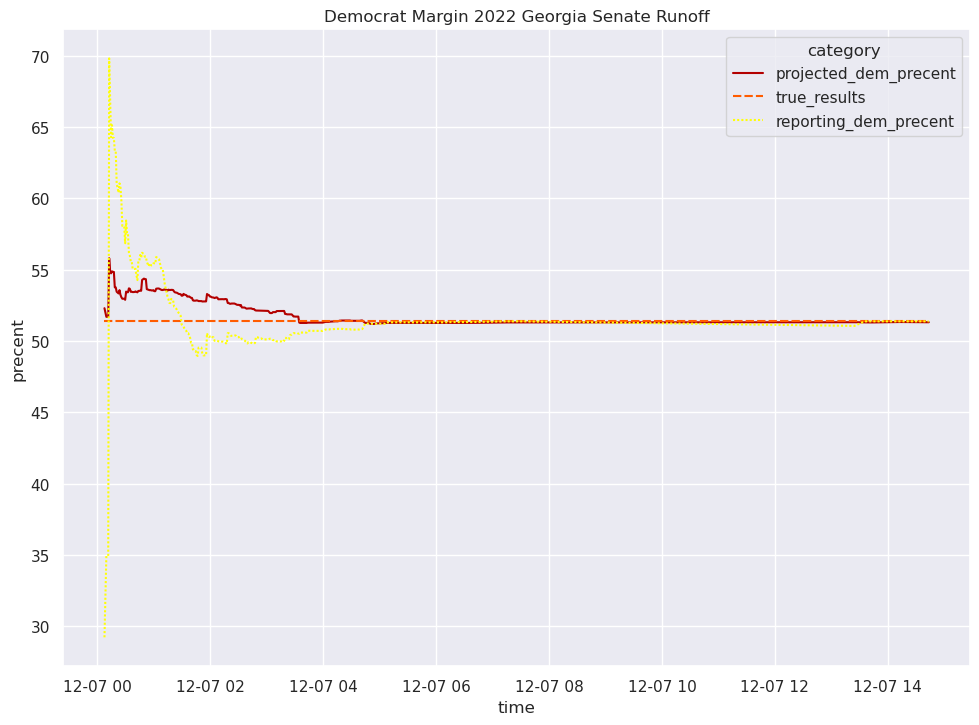

In [145]:
dem_precent_df = pd.DataFrame()
dem_precent_df['projected_dem_precent'] = projected_dem_precent
dem_precent_df['true_results'] = [final_result_dem_precent]*len(projected_dem_precent)
dem_precent_df['reporting_dem_precent'] = reporting_dem_precent
dem_precent_df=dem_precent_df*100
dem_precent_df['time']=[datetime.fromtimestamp(int(epoch)) for epoch in dem_precent_epoch ]

# Plot the responses for different events and regions
sns.lineplot(x="time", 
             y="precent",
             style="category",
             hue="category",
             palette = 'hot',
             data=dem_precent_df.melt(id_vars=['time'],
                                      var_name='category', 
                                      value_name='precent')).set(title='Democrat Margin 2022 Georgia Senate Runoff')


[Text(0.5, 1.0, 'Deviation From True Results')]

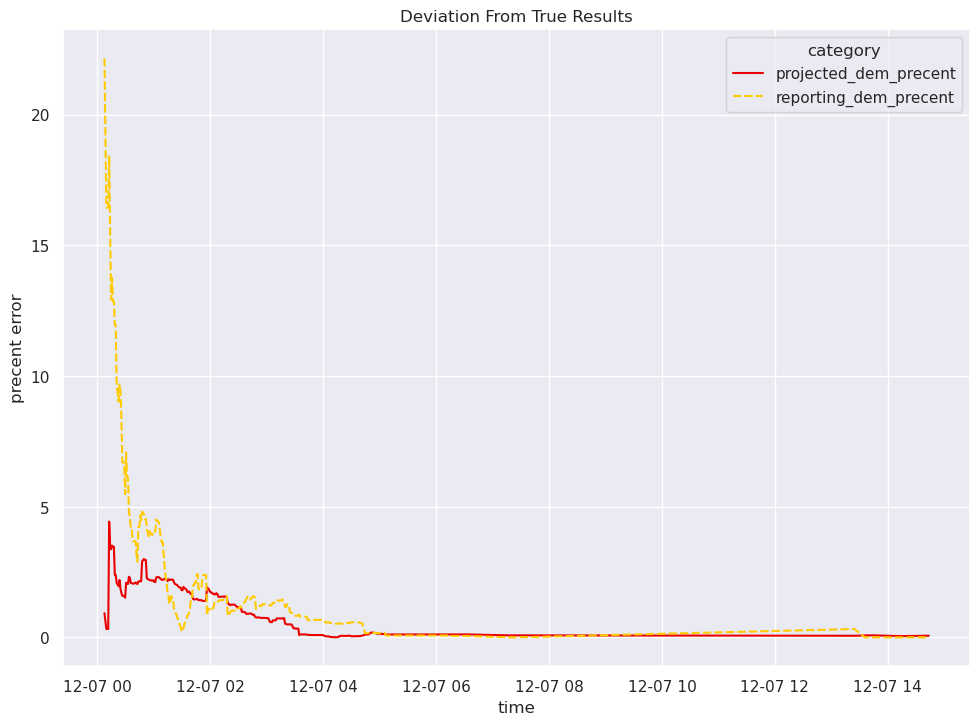

In [146]:
dem_precent_df = pd.DataFrame()
dem_precent_df['projected_dem_precent'] = projected_dem_precent
dem_precent_df['projected_dem_precent'] =abs(dem_precent_df['projected_dem_precent'] -final_result_dem_precent)
dem_precent_df['reporting_dem_precent'] = reporting_dem_precent
dem_precent_df['reporting_dem_precent'] =abs(dem_precent_df['reporting_dem_precent'] -final_result_dem_precent)
dem_precent_df=dem_precent_df*100

dem_precent_df['time']=[datetime.fromtimestamp(int(epoch)) for epoch in dem_precent_epoch ]
# Plot the responses for different events and regions
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", 
             y="precent error",
             style="category",
             hue="category",
             palette = 'hot',
             data=dem_precent_df.melt(id_vars=['time'],
                                      var_name='category',
                                      value_name='precent error')).set(title='Deviation From True Results')

These results are the best we've produced so far. Even though using projected final vote counts to calculated `projected_dem_precent` produced worse results in part 2, they actually improved our results when we apply both inter-county and intra-county models.

# Conclusion 
Applying both intra-county and inter-county model and using projected final vote totals to calculate the democrat results in our Georgia Senate runoff race produced 173% cumulative increase in accuracy over results as they were reported on election night. We have accomplished our goal of re-creating the New York Times election night needle.  